In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from numba import jit, njit, prange
from numba import config

start_time = time.time()

# Parameter
L = 256           # Lattice size LxL
T = 1        # Temperature - critical temperature is around 2.269
J = 1                 # Coupling constant (J > 0 for ferromagnetic interaction)
steps = int(512*2)            # Number of Monte Carlo steps
k_B = 1      # Boltzmann constant
H = 0              # External magnetic field
np.random.seed(42) # Set seed for reproducibility

# Initialize the lattice (random spins +1 or -1)
# @jit(nopython=True)
def initialise_lattice(L):
    # Generate a random lattice of 0s and 1s and map them to -1 and 1
    lattice = 2 * np.random.randint(0, 2, size=(L, L)) - 1
    return lattice

# Calculate the magnetisation for a spin configuration
# @jit(nopython=True)
def calc_mag(lattice):
    return np.sum(lattice)

# @jit(nopython=True)
def sum_neighbours(lattice,i,j):
    return lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]

# Calculate energy for a spin configuration
# @jit(nopython=True)
def calc_energy(lattice):
    energy = 0
    L = lattice.shape[0]
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            neighbours = sum_neighbours(lattice,i,j)
            energy += -J * S * neighbours / 2  # Each connection between neighbours is counted twice so / 2

    energy -= H * np.sum(lattice) # this is -h sum s_i
    return energy

# Monte Carlo step using Metropolis algorithm
# @jit(nopython=True)
def monte_carlo_step(lattice, T):
    for _ in range(L**2):
        i, j = np.random.randint(0, L, 2)
        S = lattice[i, j]
        # Calculate the energy difference if the spin is flipped
        neighbours = sum_neighbours(lattice,i,j)
        delta_E = 2 * J * S * neighbours
        # Metropolis criterion
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (k_B * T)):
            lattice[i, j] *= -1

268.7178089618683


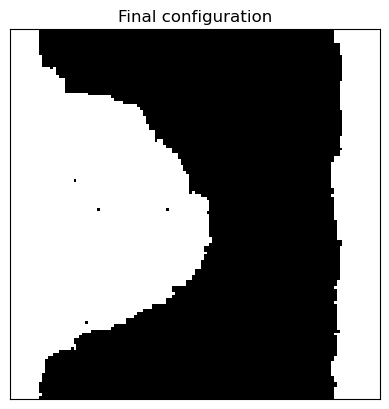

In [13]:
start_time = time.time()

L = 128
T = 1
steps = 1024

lattice = initialise_lattice(L)

for i in range(int(steps)):
    monte_carlo_step(lattice, T)

time_elapsed = time.time() - start_time
print(time_elapsed)

def plot_lattice(lattice, title):
    plt.imshow(lattice, cmap='gray', interpolation='none', vmin=-1, vmax=1)  
    plt.title(title)
    # plt.colorbar(label='Spin')

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

plot_lattice(lattice, 'Final configuration')

# Start

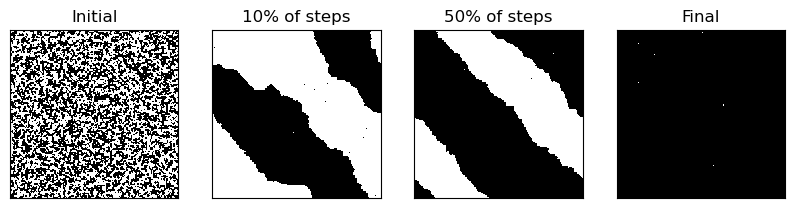

In [35]:
from numba import jit, prange
import numpy as np

@jit(nopython=True, parallel=True)
def monte_carlo_step_checkerboard(lattice, T, J=1.0, k_B=1.0):
    L = lattice.shape[0]
    updated_lattice = lattice.copy()  # Temporary array to store updates

    # Update black spins
    for i in prange(L):
        for j in range(L):
            if (i + j) % 2 == 0:  # Black spins
                S = lattice[i, j]
                neighbours = (lattice[(i+1) % L, j] + lattice[(i-1) % L, j] +
                              lattice[i, (j+1) % L] + lattice[i, (j-1) % L])
                delta_E = 2 * J * S * neighbours
                if delta_E < 0 or np.random.random() < np.exp(-delta_E / (k_B * T)):
                    updated_lattice[i, j] = -S
                else:
                    updated_lattice[i, j] = S

    lattice[:] = updated_lattice  # Apply updates for black spins

    # Update white spins
    for i in prange(L):
        for j in range(L):
            if (i + j) % 2 == 1:  # White spins
                S = lattice[i, j]
                neighbours = (lattice[(i+1) % L, j] + lattice[(i-1) % L, j] +
                              lattice[i, (j+1) % L] + lattice[i, (j-1) % L])
                delta_E = 2 * J * S * neighbours
                if delta_E < 0 or np.random.random() < np.exp(-delta_E / (k_B * T)):
                    updated_lattice[i, j] = -S
                else:
                    updated_lattice[i, j] = S

    lattice[:] = updated_lattice  # Apply updates for white spins


magnetisation = np.zeros(steps)
energy = np.zeros(steps)
lattice = initialise_lattice(L)
lattice_histories = []

# config.NUMBA_NUM_THREADS = 1

for i in range(steps):
    monte_carlo_step_checkerboard(lattice, T)
    # monte_carlo_step(lattice, T)

    magnetisation[i] = calc_mag(lattice)/L**2
    energy[i] = calc_energy(lattice)/L**2
    lattice_histories.append(lattice.copy())

def plot_lattice(lattice, title):
    plt.imshow(lattice, cmap='gray', interpolation='none', vmin=-1, vmax=1)  
    plt.title(title)
    # plt.colorbar(label='Spin')

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

# Plot the "before" state
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)  # Create subplot for the "before" state
plot_lattice(lattice_histories[0], 'Initial')

# Plot the "after" state
plt.subplot(1, 4, 2)  # Create subplot for the "after" state
plot_lattice(lattice_histories[round(steps/10)], '10% of steps')

# Plot the "after" state
plt.subplot(1, 4, 3)  # Create subplot for the "after" state
plot_lattice(lattice_histories[round(steps/2)], '50% of steps')

# Plot the "after" state
plt.subplot(1, 4, 4)  # Create subplot for the "after" state
plot_lattice(lattice, 'Final')

plt.show()


In [324]:
# Main simulation

# Initialize the lattice


sims = 1
store = []
temps = [1]
# temps = [1]

# Perform the simulation
for Temp in temps:
    T = Temp
    for j in range(sims):
        
        lattice = initialise_lattice(L)
        magnetisation = np.zeros(steps)
        energy = np.zeros(steps)
        lattice_histories = []

        for i in range(steps):
            monte_carlo_step(lattice, T)
            magnetisation[i] = calc_mag(lattice)/L**2
            energy[i] = calc_energy(lattice)/L**2
            lattice_histories.append(lattice.copy())
            if np.var(magnetisation[i-64:i]) < 1e-6:
                print(i)

        store.append(energy)


    

c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264


KeyboardInterrupt: 

# Plot magnetisation

Text(0.5, 1.0, 'Energy per step vs MC steps for 8 runs')

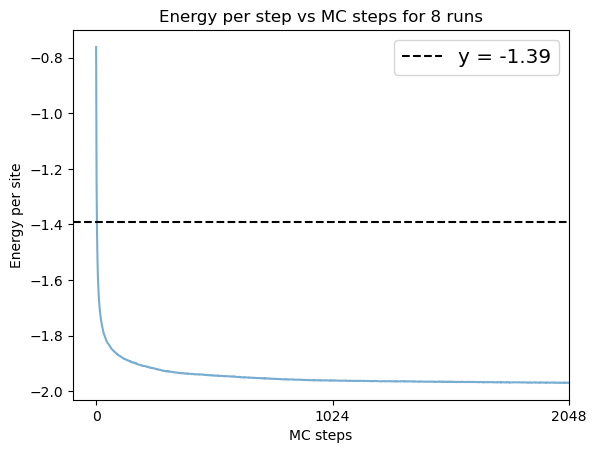

In [276]:
# Plot the magnetisation and energy

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)  # Create subplot for the magnetisation
# plt.plot(magnetisation)
# plt.xlabel('MC steps')
# plt.ylabel('Magnetisation')
# plt.title('Magnetisation vs MC steps')

# plt.subplot(1, 2, 2)  # Create subplot for the energy
for i in range(sims*len(temps)):
    plt.plot(store[i], alpha=0.6)
#put line at y = -1.4
plt.axhline(y=-1.39, color='black', linestyle='--', label = f"y = -1.39")
plt.xlabel('MC steps')
plt.ylabel('Energy per site')
plt.xticks(range(0, len(store[0]) + 1, 1024))  # Set x-axis ticks in steps of 1024
plt.xlim(-100,steps)
plt.legend(fontsize = "x-large")
plt.title('Energy per step vs MC steps for 8 runs')




In [272]:
# Find mean value between step 1000 and 2000

mean_energy = []

for i in range(sims):
    mean_energy.append(np.mean(store[i][1024:,]))
    print(mean_energy)
overall = np.mean(mean_energy)


mean_energy = np.mean(store[0][1024*2:,])
print(energy[1024])
print(mean_energy)
print(overall)

# print(np.mean(store[5][1024:,]))

[-1.9647498726844788]
-1.9576873779296875
nan
-1.9647498726844788


c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Inigo\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Different Temps

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.8500000000000005
4.9
4.95
5.0


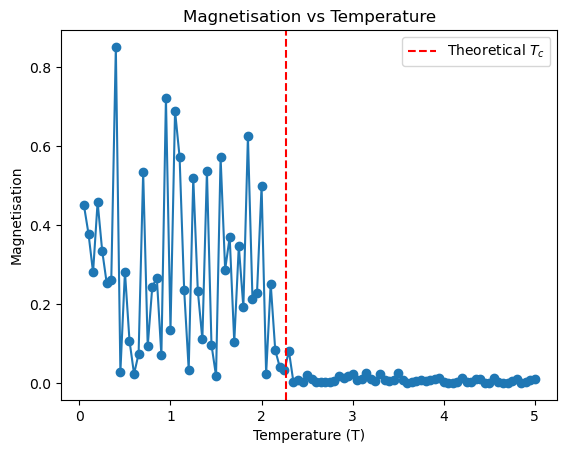

In [219]:
# Simulate for different temperatures
temperatures = np.linspace(0.05, 5, 100)
magnetizations = []

L = 256
steps = 2048

for T in temperatures:
    # Initialize the lattice
    print(T)
    lattice = initialise_lattice(L) 
    
    # Run the simulation
    for step in range(steps):
        monte_carlo_step(lattice, T)
    
    # After thermalization, calculate the average magnetization
    mag = np.abs(calc_mag(lattice)) / (L * L)  # Normalize by number of spins
    magnetizations.append(mag)

# Plot results
plt.plot(temperatures, magnetizations, '-o')
plt.axvline(x=2.269, color='r', linestyle='--', label="Theoretical $T_c$")
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetisation")
plt.title("Magnetisation vs Temperature")
plt.legend()
plt.show()

In [218]:
temperatures = np.linspace(0.05, 5, 100)
print(temperatures)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1
 2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8
 2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45 3.5
 3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2
 4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9
 4.95 5.  ]


In [220]:
# save themagnetisation

np.save("magnetisations", magnetizations)

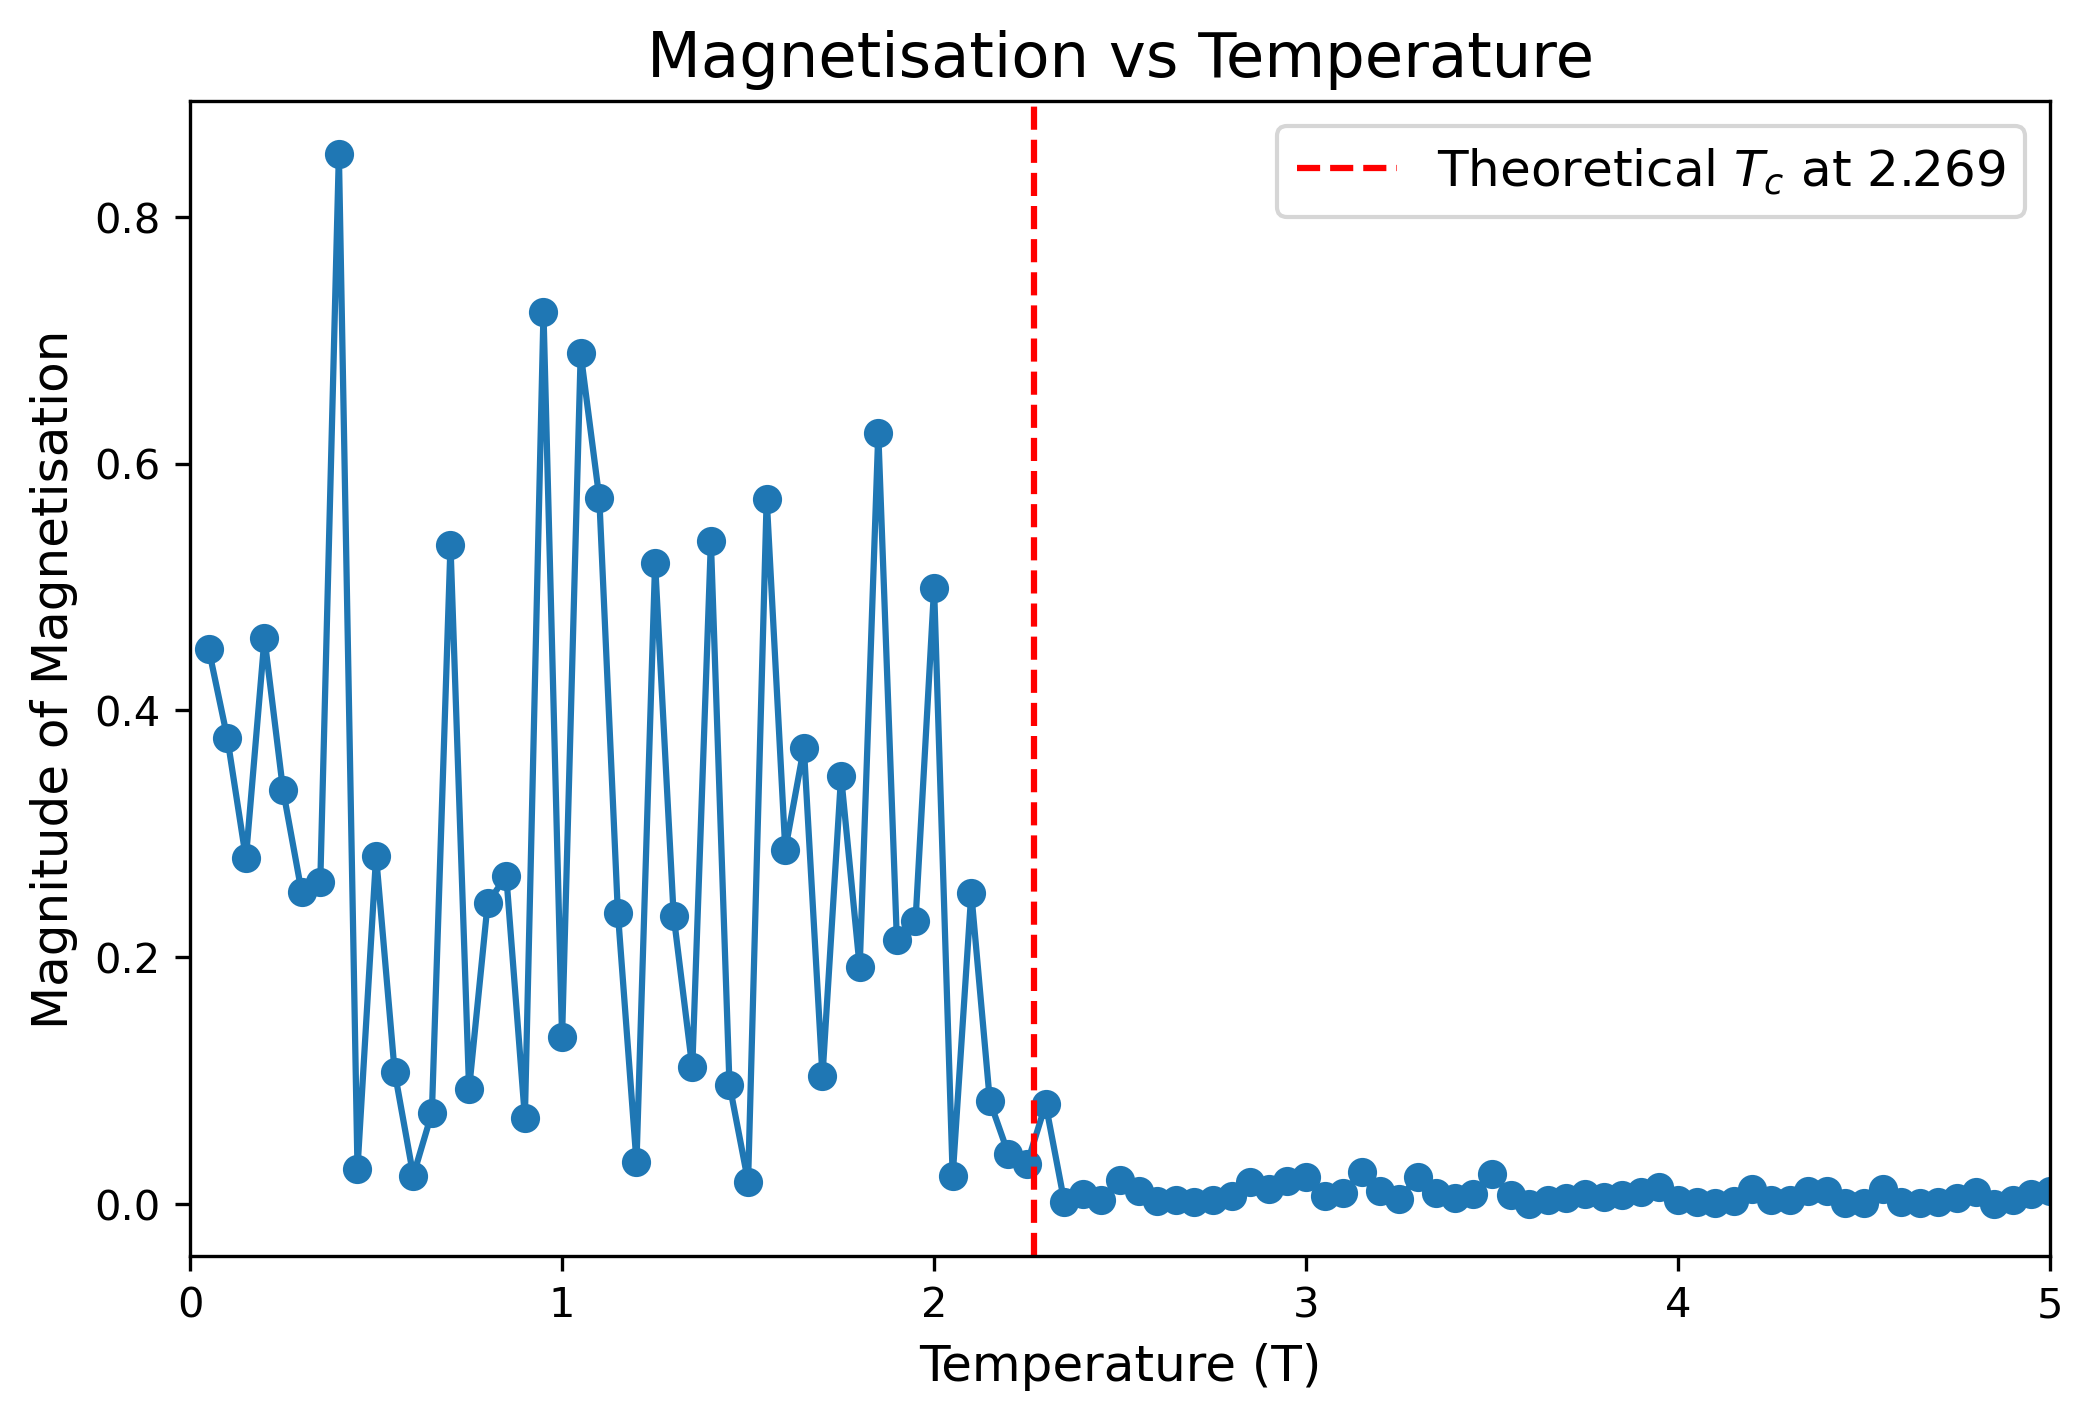

In [15]:
# Lattice = 256, steps = 2048, time = 25mins
temperatures = np.linspace(0.05, 5, 100)
magnetizations = np.load("magnetisationsvT.npy")
plt.figure(figsize=(8,5), dpi=300)
# increase dpi for better resolution

plt.plot(temperatures, magnetizations, '-o')
plt.axvline(x=2.269, color='r', linestyle='--', label="Theoretical $T_c$ at 2.269")
plt.xlabel("Temperature (T)", fontsize = 12)
plt.ylabel("Magnitude of Magnetisation", fontsize = 12)
plt.title("Magnetisation vs Temperature", fontsize = 15)
plt.xlim(0,5)
plt.legend(fontsize = "large")
plt.ion()
plt.show()

In [228]:
new  = np.load("magnetisations.npy")

print(new)

[4.49768066e-01 3.77899170e-01 2.80151367e-01 4.58312988e-01
 3.35235596e-01 2.52563477e-01 2.60803223e-01 8.51165771e-01
 2.85644531e-02 2.81829834e-01 1.06872559e-01 2.28881836e-02
 7.37915039e-02 5.33782959e-01 9.29870605e-02 2.43652344e-01
 2.65930176e-01 6.99768066e-02 7.22503662e-01 1.35223389e-01
 6.89208984e-01 5.72174072e-01 2.35900879e-01 3.38745117e-02
 5.19287109e-01 2.33306885e-01 1.10534668e-01 5.36834717e-01
 9.66491699e-02 1.80664062e-02 5.71563721e-01 2.87170410e-01
 3.69659424e-01 1.03576660e-01 3.46740723e-01 1.91864014e-01
 6.24694824e-01 2.13684082e-01 2.28942871e-01 4.99084473e-01
 2.23999023e-02 2.51708984e-01 8.30993652e-02 4.02221680e-02
 3.24096680e-02 8.08410645e-02 1.64794922e-03 8.23974609e-03
 2.89916992e-03 1.92565918e-02 1.03759766e-02 2.13623047e-03
 3.08227539e-03 1.49536133e-03 3.47900391e-03 5.98144531e-03
 1.76696777e-02 1.21154785e-02 1.87683105e-02 2.21252441e-02
 6.50024414e-03 9.12475586e-03 2.56042480e-02 1.00708008e-02
 3.99780273e-03 2.203369

# Plot energy v steps for finding equib

In [ ]:
# Plot energy against step for differnet temps 

L = 256

temps = [0.1, 1, 2, 2.269, 3, 4, 5]
# temps = [0.1]

energy2 = []
steps = 16384

for i in temps:
    T = i
    lattice = initialise_lattice(L)
    energy = np.zeros(steps)

    for i in range(steps):
        monte_carlo_step(lattice, T)
        energy[i] = calc_energy(lattice)/L**2

    energy2.append(energy)
    print(i)



16383
16383
16383
16383
16383
16383
16383


Text(0.5, 1.0, 'Energy per Site vs MC Sweeps for Different Temperatures')

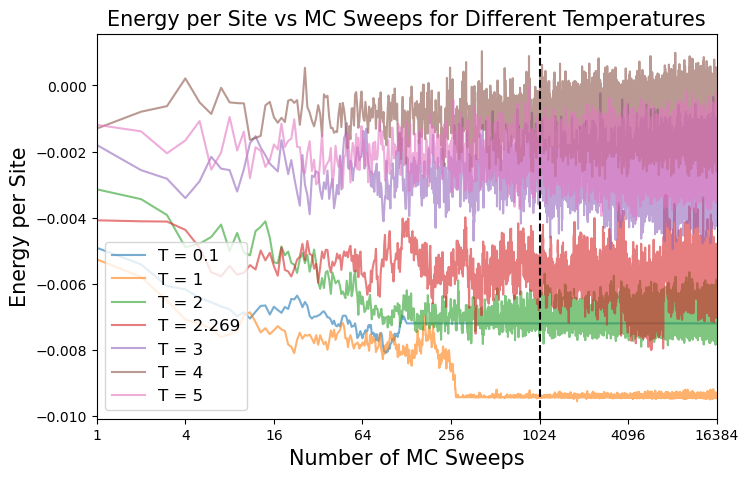

In [27]:
# Now plot the energy for each temperature
plt.figure(figsize=(8, 5))

for i in range(len(temps)):
    plt.plot(range(steps), (energy2[i]), alpha=0.6, label = f"T = {temps[i]}")
plt.xlabel('Number of MC Sweeps', fontsize = 15)
plt.ylabel('Energy per Site', fontsize = 15)
# plt.yscale('log')
plt.xscale('log')
plt.xlim(1,steps)
plt.legend(loc = "lower left", fontsize = "large")
plt.axvline(x=1024, color='black', linestyle='--', label = f"x = 1024")
plt.xticks([4**i for i in range(0,8)], labels= [4**i for i in range(0,8)])
plt.tick_params(axis='x', which='minor', bottom=False)
plt.title('Energy per Site vs MC Sweeps for Different Temperatures', fontsize = 15)
# make plot wider

# plt.xticks(range(0, len(energy2[0]) + 1, 1024))  # Set x-axis ticks in steps of 1024

In [24]:
import numpy as np

L = 256
temps = [0.1, 1, 2, 2.269, 3, 4, 5]
steps = 16384

# Function placeholders
# Make sure to define initialise_lattice, monte_carlo_step, and calc_energy in your code

energy_avg = []  # List to store averaged energy arrays

for T in temps:
    runs = 3  # Number of runs for each temperature
    energy_runs = np.zeros((runs, steps))  # Array to store energies for each run
    
    for run in range(runs):
        lattice = initialise_lattice(L)
        energy = np.zeros(steps)
        
        for step in range(steps):
            monte_carlo_step(lattice, T)
            energy[step] = calc_energy(lattice) / L**2
        
        energy_runs[run] = energy  # Store the energy array for this run

    # Average over runs
    avg_energy = np.mean(energy_runs, axis=0)
    energy_avg.append(avg_energy)
    print(f"Temperature: {T}, Run: {run + 1} complete")

# energy_avg now contains averaged energy arrays for each temperature


Temperature: 0.1, Run: 3 complete
Temperature: 1, Run: 3 complete
Temperature: 2, Run: 3 complete
Temperature: 2.269, Run: 3 complete
Temperature: 3, Run: 3 complete
Temperature: 4, Run: 3 complete
Temperature: 5, Run: 3 complete


Text(0.5, 1.0, 'Energy per Site vs MC Sweeps for Different Temperatures')

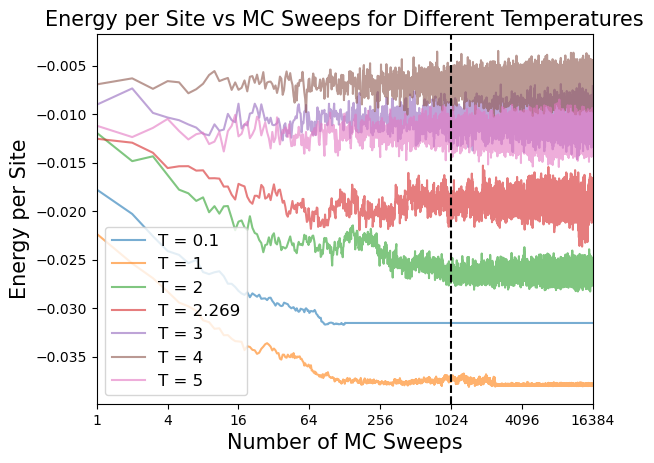

In [26]:
for i in range(len(temps)):
    plt.plot(range(steps), energy_avg[i], alpha=0.6, label=f"T = {temps[i]}")  # Use energy_avg
plt.xlabel('Number of MC Sweeps', fontsize=15)
plt.ylabel('Energy per Site', fontsize=15)
plt.xscale('log')  # Log scale for x-axis
plt.xlim(1, steps)  # Set x-axis limits
plt.legend(loc="lower left", fontsize="large")
plt.axvline(x=1024, color='black', linestyle='--', label = f"x = 1024")
plt.xticks([4**i for i in range(0,8)], labels= [4**i for i in range(0,8)])
plt.tick_params(axis='x', which='minor', bottom=False)
plt.title('Energy per Site vs MC Sweeps for Different Temperatures', fontsize = 15)

# Plotting lattices

In [68]:
L = 256
steps = 1024
T = 1
temps = [1,2.269,5]

magnetisation = np.zeros(steps)
energy = np.zeros(steps)
lattice = initialise_lattice(L)
lattice_histories_overall = []

for temp in temps:
    lattice = initialise_lattice(L)
    lattice_histories = []
    T = temp
    for i in range(steps):
        monte_carlo_step(lattice, T)
        magnetisation[i] = calc_mag(lattice)/L**2
        energy[i] = calc_energy(lattice)/L**2
        lattice_histories.append(lattice.copy())
    lattice_histories_overall.append(lattice_histories)


1
1
1


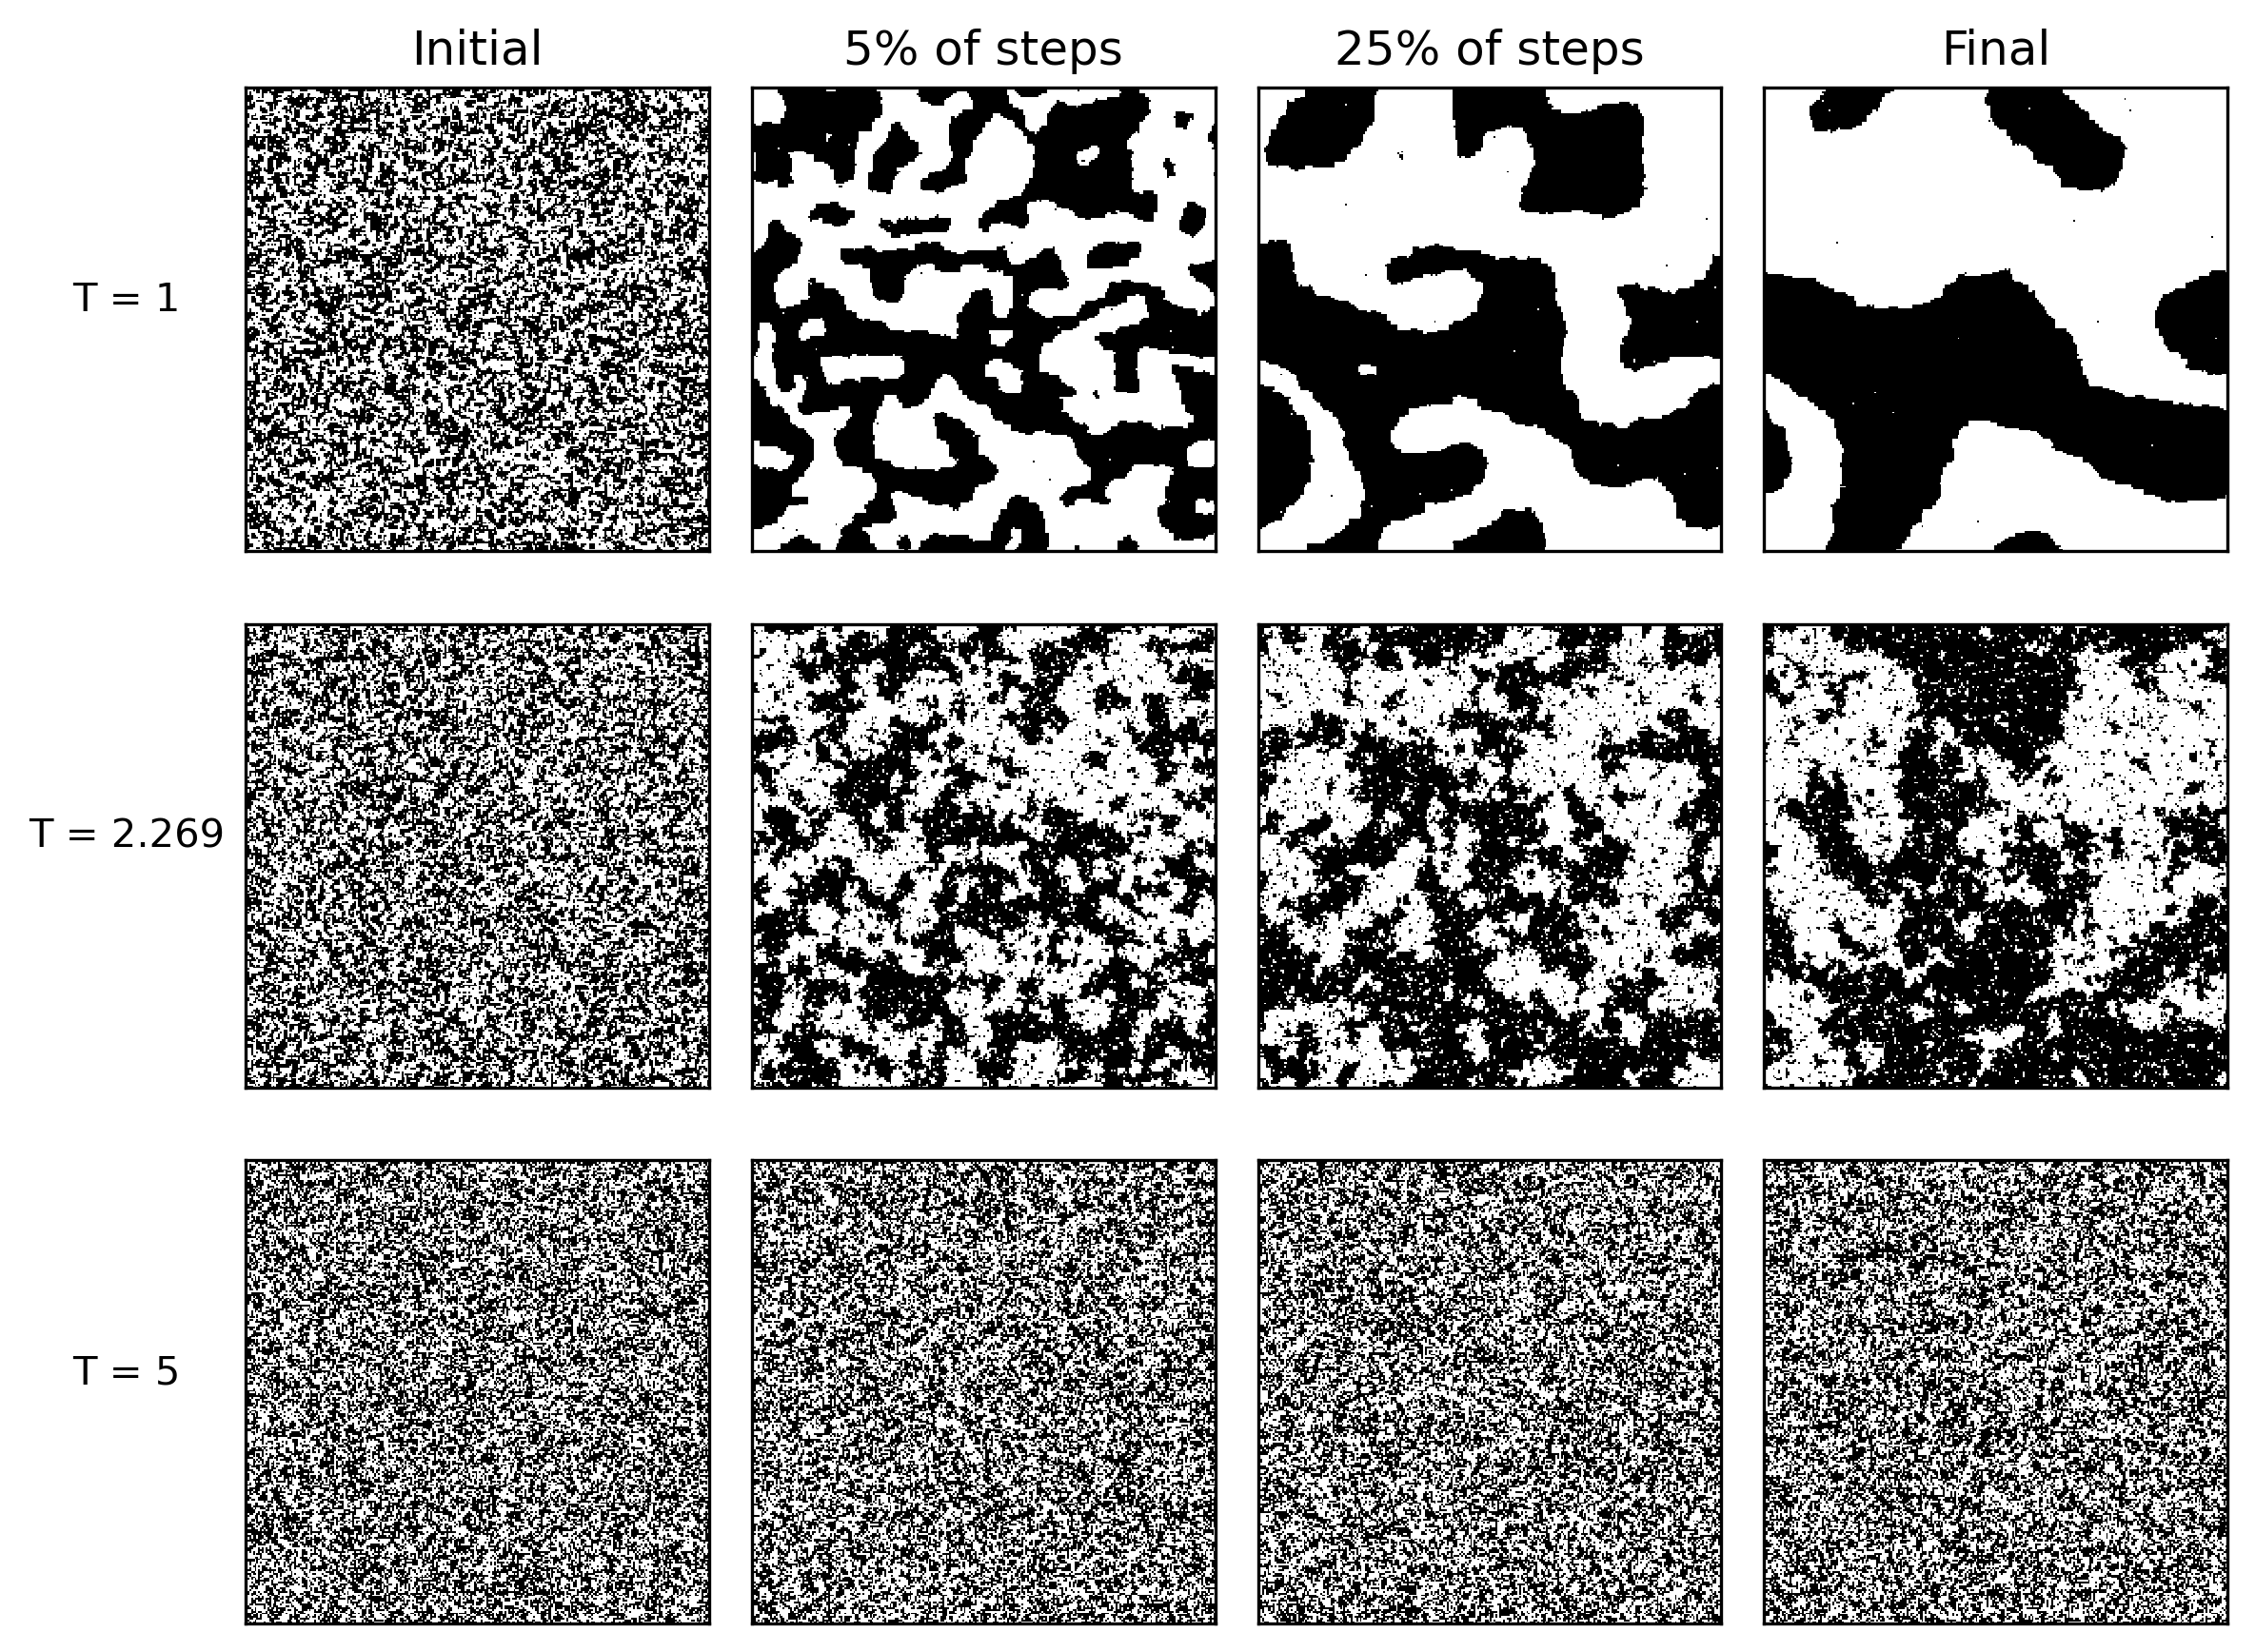

In [91]:
def plot_lattice(lattice, title=None, ytitle=None):
    plt.imshow(lattice, cmap='gray', interpolation='none', vmin=-1, vmax=1)
    if title is not None:  
        plt.title(title)    
    if ytitle is not None: 
        print(1) 
        plt.ylabel(ytitle, rotation = 0, labelpad= 30)

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

# Plot the "before" state
plt.figure(figsize=(8, 6), dpi = 300)

plt.subplot(3, 4, 1)  # Create subplot for the "before" state
plot_lattice(lattice_histories_overall[0][0], 'Initial', 'T = 1')

# Plot the "after" state
plt.subplot(3, 4, 2)  # Create subplot for the "after" state
plot_lattice(lattice_histories_overall[0][round(steps/20)], '5% of steps')

# Plot the "after" state
plt.subplot(3, 4, 3)  # Create subplot for the "after" state
plot_lattice(lattice_histories_overall[0][round(steps/4)], '25% of steps')

# Plot the "after" state
plt.subplot(3, 4, 4)  # Create subplot for the "after" state
plot_lattice(lattice_histories_overall[0][-1], 'Final')

plt.subplot(3, 4, 5)
plot_lattice(lattice_histories_overall[1][0], ytitle = 'T = 2.269')

plt.subplot(3, 4, 6)
plot_lattice(lattice_histories_overall[1][round(steps/20)])

plt.subplot(3, 4, 7)
plot_lattice(lattice_histories_overall[1][round(steps/4)])

plt.subplot(3, 4, 8)
plot_lattice(lattice_histories_overall[1][-1])

plt.subplot(3, 4, 9)
plot_lattice(lattice_histories_overall[2][0], ytitle = 'T = 5')

plt.subplot(3, 4, 10)
plot_lattice(lattice_histories_overall[2][round(steps/20)])

plt.subplot(3, 4, 11)
plot_lattice(lattice_histories_overall[2][round(steps/4)])

plt.subplot(3, 4, 12)
plot_lattice(lattice_histories_overall[2][-1])

plt.tight_layout()
plt.show()

# 3 D

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit

start_time = time.time()

# Parameters
L = 32           # Lattice size LxLxL (reduce size for 3D to keep things manageable)
T = 1            # Temperature
J = 1.0          # Coupling constant (J > 0 for ferromagnetic interaction)
steps = 1024      # Number of Monte Carlo steps
k_B = 1          # Boltzmann constant
H = 0            # External magnetic field
np.random.seed(42)  # Set seed for reproducibility

# Initialize the lattice (random spins +1 or -1) in 3D
@jit(nopython=True)
def initialise_lattice(L):
    # Generate a random 3D lattice of 0s and 1s and map them to -1 and 1
    lattice = 2 * np.random.randint(0, 2, size=(L, L, L)) - 1
    return lattice

# Calculate the magnetisation for a spin configuration in 3D
@jit(nopython=True)
def calc_mag(lattice):
    return np.sum(lattice)

# Sum the neighbors in the 3D lattice
@jit(nopython=True)
def sum_neighbours(lattice, i, j, k, L):
    return (lattice[(i+1)%L, j, k] + lattice[(i-1)%L, j, k] +  # neighbors in x-direction
            lattice[i, (j+1)%L, k] + lattice[i, (j-1)%L, k] +  # neighbors in y-direction
            lattice[i, j, (k+1)%L] + lattice[i, j, (k-1)%L])   # neighbors in z-direction

# Calculate energy for a spin configuration in 3D
@jit(nopython=True)
def calc_energy(lattice, L, J, H):
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                S = lattice[i, j, k]
                neighbours = sum_neighbours(lattice, i, j, k, L)
                energy += -J * S * neighbours / 2  # Each pair counted twice
    energy -= H * np.sum(lattice)
    return energy

# Monte Carlo step using Metropolis algorithm in 3D
@jit(nopython=True)
def monte_carlo_step(lattice, T, L, J, k_B):
    for _ in range(L**3):  # Iterate over all lattice points
        i, j, k = np.random.randint(0, L, 3)  # Choose random spin to flip
        S = lattice[i, j, k]
        # Calculate the energy difference if the spin is flipped
        neighbours = sum_neighbours(lattice, i, j, k, L)
        delta_E = 2 * J * S * neighbours
        # Metropolis criterion
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (k_B * T)):
            lattice[i, j, k] *= -1  # Flip the spin

# Run simulation
lattice = initialise_lattice(L)
before_lattice = lattice.copy()  # Save the initial lattice state for plotting

energies = []
magnetizations = []
lattice_histories = []

for step in range(steps):
    monte_carlo_step(lattice, T, L, J, k_B)
    
    energy = calc_energy(lattice, L, J, H)
    magnetization = np.sum(lattice)
    energies.append(energy)
    magnetizations.append(magnetization)

    # Create array of all lattice states
    lattice_histories.append(lattice.copy())

end_time = time.time()
elapsed_time = end_time - start_time  # Calculate the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")






Elapsed time: 54.37 seconds


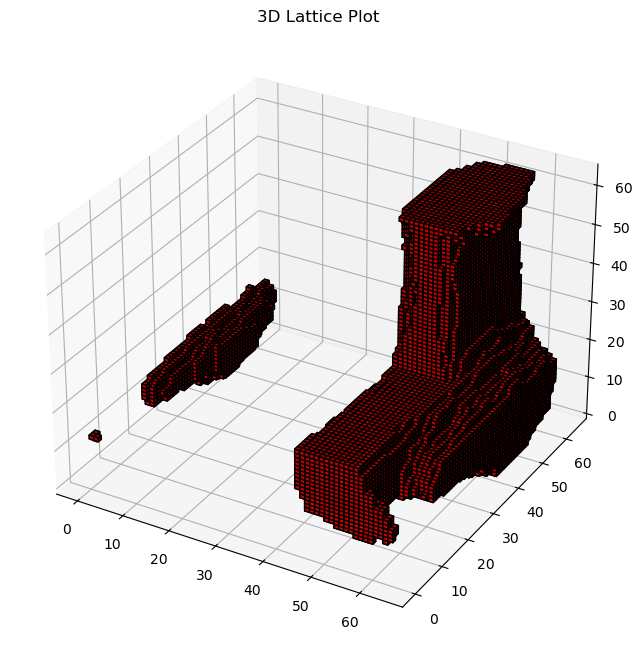

In [55]:
# Function to visualize a slice of the lattice in 2D (since 3D is hard to visualize directly)
def plot_lattice_slice(lattice, slice_index, title):
    plt.imshow(lattice[slice_index], cmap='gray', interpolation='none', vmin=-1, vmax=1)  # Show a 2D slice
    plt.title(title)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

# Function to plot the 3D lattice as voxels
def plot_3d_voxels(lattice):
    L = lattice.shape[0]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D grid of colors based on the spins (+1 = red, -1 = blue)
    colors = np.empty(lattice.shape, dtype=object)
    colors[lattice == 1] = 'red'
    colors[lattice == -1] = 'blue'

    # Create a voxel plot with color mapping
    ax.voxels(lattice == 1, facecolors=colors, edgecolor='k', alpha = 0.8)

    # Set labels
    # ax.set_xlabel('X axis')
    # ax.set_ylabel('Y axis')
    # ax.set_zlabel('Z axis')
    ax.set_title('3D Lattice Plot')

    plt.show()

# Example: Plot the final state of the lattice in 3D voxels
plot_3d_voxels(lattice_histories[-1])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm


# Parameters
L = 32           # Lattice size
steps = 512     # Number of Monte Carlo steps
J = 1.0          # Coupling constant
k_B = 1          # Boltzmann constant
H = 0            # External magnetic field

# Initialize the lattice (random spins +1 or -1) in 3D
@jit(nopython=True)
def initialise_lattice(L):
    lattice = 2 * np.random.randint(0, 2, size=(L, L, L)) - 1
    return lattice

# Sum the neighbors in the 3D lattice
@jit(nopython=True)
def sum_neighbours(lattice, i, j, k, L):
    return (lattice[(i+1)%L, j, k] + lattice[(i-1)%L, j, k] +  # Neighbors in x-direction
            lattice[i, (j+1)%L, k] + lattice[i, (j-1)%L, k] +  # Neighbors in y-direction
            lattice[i, j, (k+1)%L] + lattice[i, j, (k-1)%L])   # Neighbors in z-direction

# Monte Carlo step using Metropolis algorithm in 3D
@jit(nopython=True)
def monte_carlo_step(lattice, T, L, J, k_B):
    for _ in range(L**3):  # Iterate over all lattice points
        i, j, k = np.random.randint(0, L, 3)  # Choose random spin to flip
        S = lattice[i, j, k]
        neighbours = sum_neighbours(lattice, i, j, k, L)
        delta_E = 2 * J * S * neighbours
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (k_B * T)):
            lattice[i, j, k] *= -1  # Flip the spin

# Function to plot the 3D lattice as voxels
def plot_3d_lattice(ax, lattice, title):
    L = lattice.shape[0]
    colors = np.empty(lattice.shape, dtype=object)
    colors[lattice == 1] = 'red'
    colors[lattice == -1] = 'blue'
    ax.voxels(lattice == 1, facecolors=colors, edgecolor='k', alpha=0.8)
    ax.set_title(title, fontsize=10)
    ax.axis('off')  # Turn off axes for clarity

lattices3d = []
temps = [1, 4.54, 10]  # Temperatures to simulate

# Run simulations for each temperature
fig = plt.figure(figsize=(15, 5), dpi=300)

for idx, T in enumerate(temps):
    print(T)
    lattice = initialise_lattice(L)
    for step in tqdm(range(steps)):
        monte_carlo_step(lattice, T, L, J, k_B)

    # Plot the final state of the lattice in 3D
    lattices3d.append(lattice)
    # ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    # plot_3d_lattice(ax, lattice, f"T = {T}")

# Add a centralized title
# plt.suptitle("3D Ising Model: Final State for Different Temperatures", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


1


100%|██████████| 512/512 [00:01<00:00, 260.11it/s]


4.54


100%|██████████| 512/512 [00:01<00:00, 277.59it/s]


10


100%|██████████| 512/512 [00:01<00:00, 276.01it/s]


<Figure size 4500x1500 with 0 Axes>

In [31]:
print(lattices3d[1].shape)

latticet2 = []

temps = [2]

for idx, T in enumerate(temps):
    print(T)
    lattice = initialise_lattice(L)
    for step in tqdm(range(steps)):
        monte_carlo_step(lattice, T, L, J, k_B)

    # Plot the final state of the lattice in 3D
    latticet2.append(lattice)


(32, 32, 32)
2


100%|██████████| 1024/1024 [00:03<00:00, 299.43it/s]


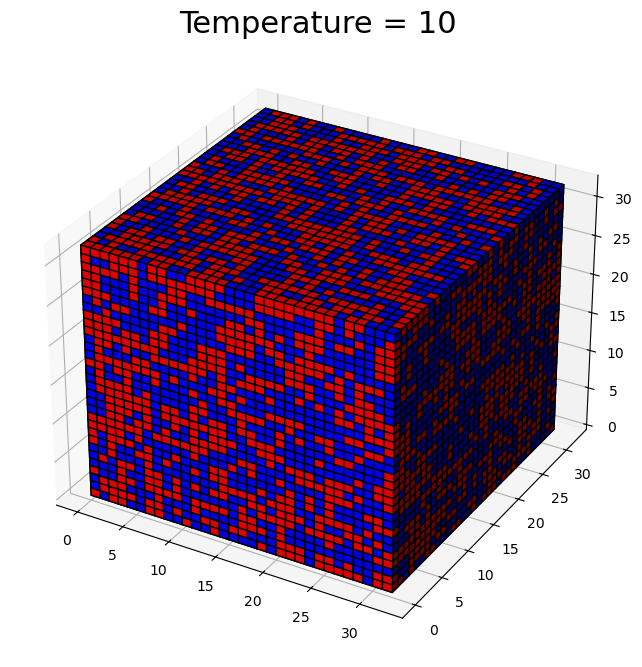

In [44]:
def plot_3d_voxels(lattice, title):
    L = lattice.shape[0]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D grid of colors based on the spins (+1 = red, -1 = blue)
    colors = np.empty(lattice.shape, dtype=object)
    colors[lattice == 1] = 'red'
    colors[lattice == -1] = 'blue'

    # Create a voxel plot with color mapping
    ax.voxels(lattice == 1, facecolors=colors, edgecolor='k', alpha = 1)
    ax.voxels(lattice == -1, facecolors=colors, edgecolor='k', alpha = 1)

    ax.set_title(title, fontsize = 22)

    plt.show()

# for i in range(temps):
#      subplot = 1
#      plot_3d_voxels(lattices3d[i])

# plot_3d_voxels(latticet2[0], "Temperature = 2")
plot_3d_voxels(lattices3d[2], "Temperature = 10")

In [ ]:
for T in [1, 4.54, 10]:
    lattice = initialise_lattice(L)
    energies = np.zeros(steps)
    magnetizations = np.zeros(steps)

    for step in range(steps):
        monte_carlo_step(lattice, T, L, J, k_B)
        energies[step] = calc_energy(lattice, L, J, H)
        magnetizations[step] = np.sum(lattice)

    plt.subplot

# 3d temp

In [10]:
# Simulate for different temperatures
temperatures = np.linspace(0.05, 10, 20)
magnetizations = []

L = 64
steps = 1024

for T in temperatures:
    # Initialize the lattice
    print(T)
    lattice = initialise_lattice(L) 
    
    # Run the simulation
    for step in range(steps):
        monte_carlo_step(lattice, T, L, J, k_B)
    
    # After thermalization, calculate the average magnetization
    mag = np.abs(calc_mag(lattice)) / (L * L * L)  # Normalize by number of spins
    magnetizations.append(mag)



0.05
0.5736842105263158
1.0973684210526315
1.6210526315789473
2.144736842105263
2.6684210526315786
3.1921052631578943
3.71578947368421
4.239473684210526
4.763157894736842
5.286842105263157
5.810526315789473
6.334210526315789
6.857894736842105
7.38157894736842
7.905263157894736
8.428947368421053
8.952631578947368
9.476315789473684
10.0


In [14]:
#save the data

np.save("magnetisationsvT3D", magnetizations)

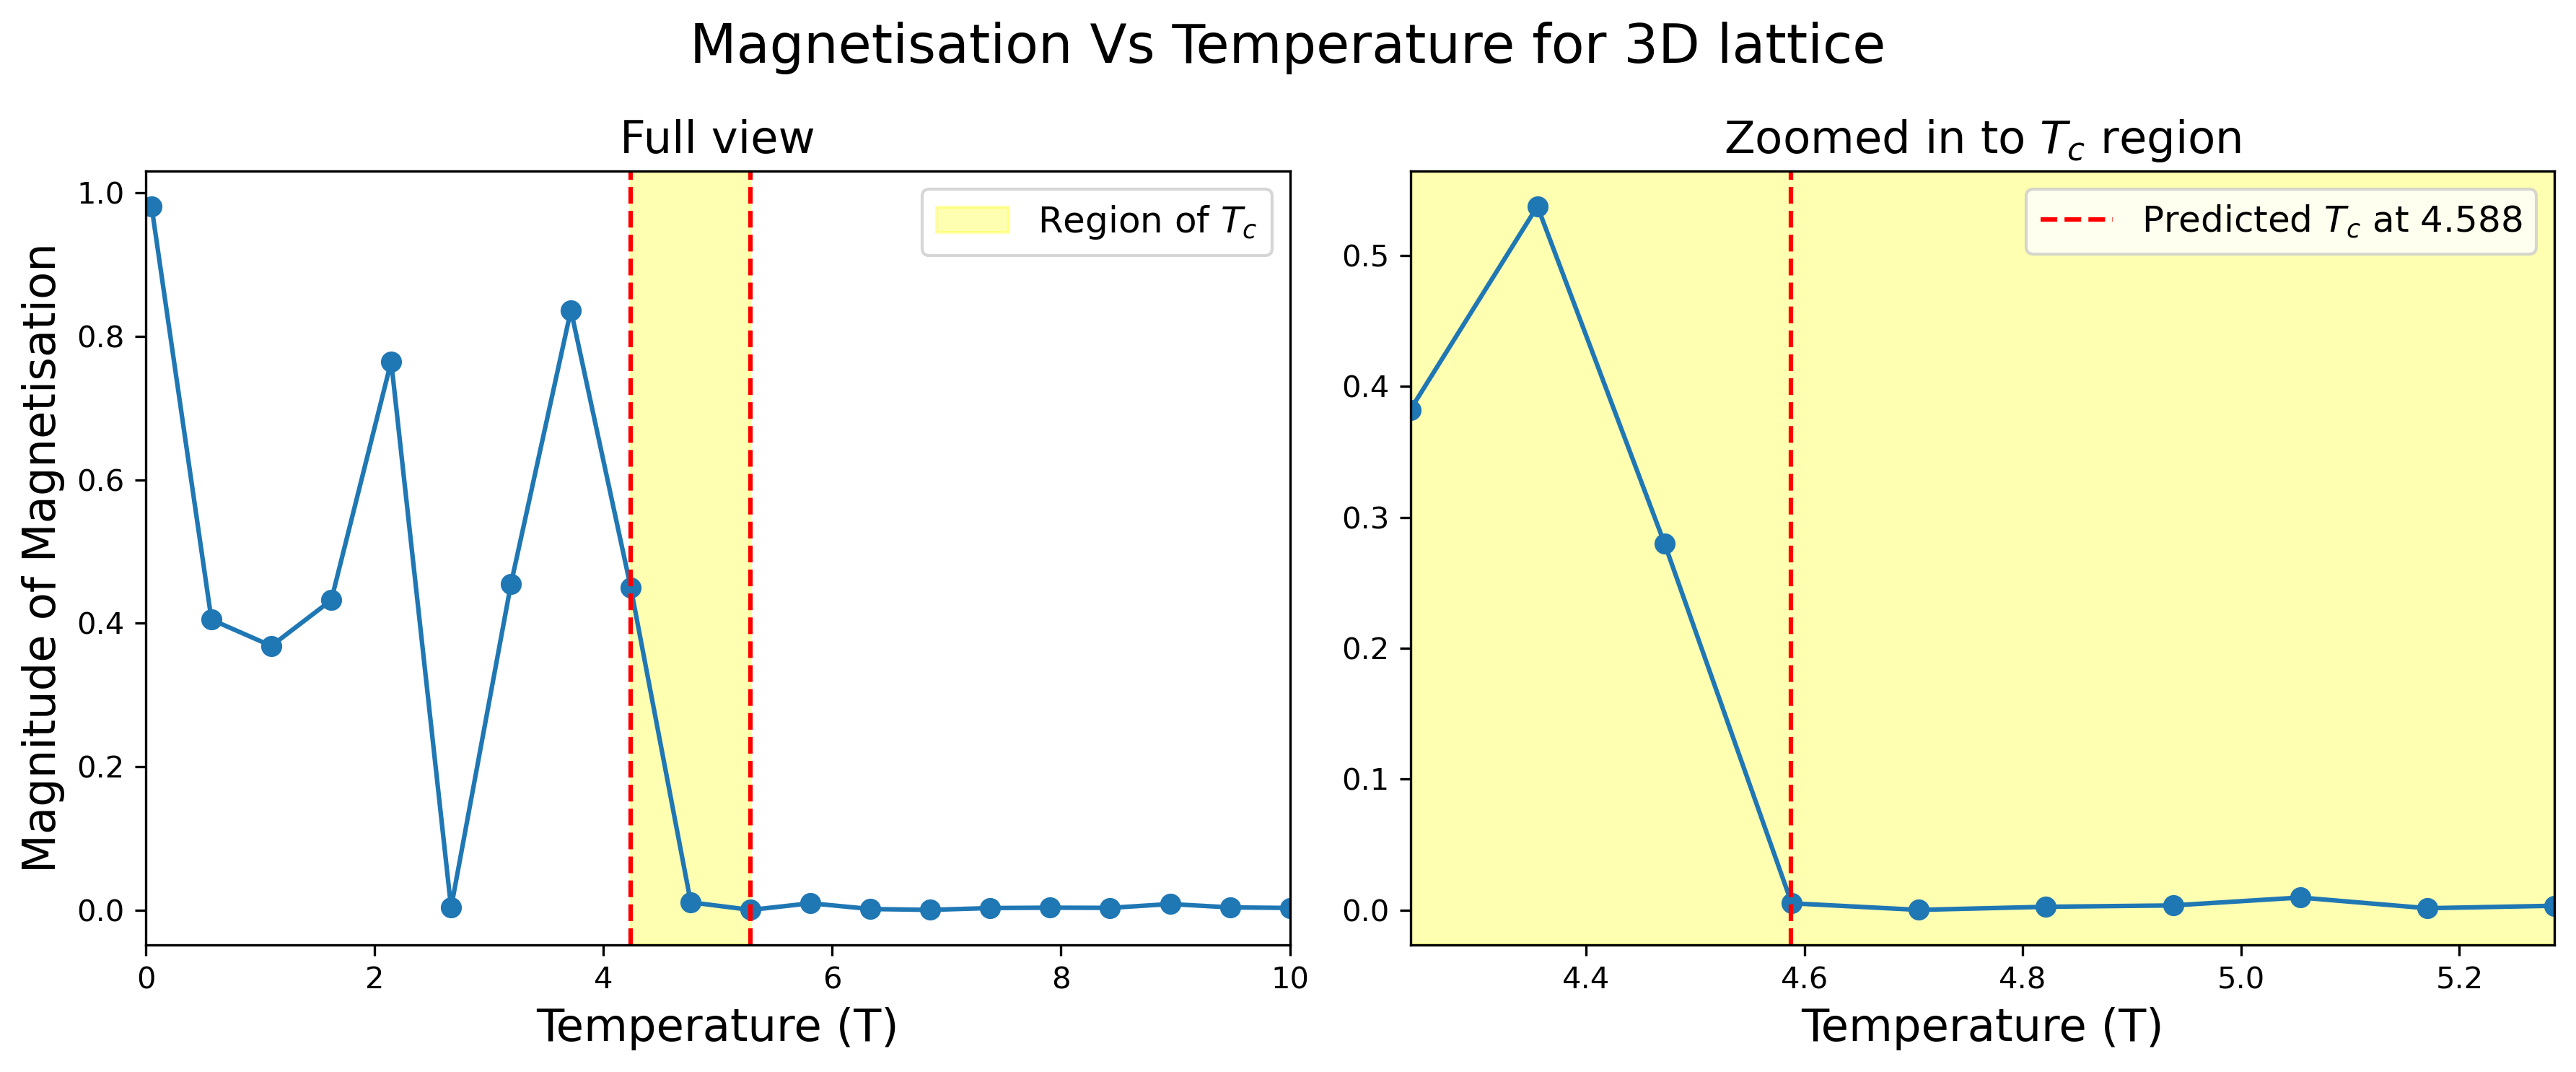

In [48]:
temperatures = np.linspace(0.05, 10, 20)
magnetizations = np.load("magnetisationsvT3D.npy")


# Create subplot of 2
plt.figure(figsize=(12,5), dpi=300)

plt.subplot(1, 2, 1)


# increase dpi for better resolution

plt.plot(temperatures, magnetizations, '-o')
plt.axvline(x=4.239, color='r', linestyle='--')
plt.axvline(x=5.287, color='r', linestyle='--')
plt.axvspan(4.239, 5.287, color='yellow', alpha=0.3, label='Region of $T_c$')
plt.xlabel("Temperature (T)", fontsize = 15)
plt.ylabel("Magnitude of Magnetisation", fontsize = 15)
plt.title("Full view", fontsize = 15)
plt.xlim(0,10)
plt.legend(fontsize = "large")
plt.ion()
# plt.show()

plt.subplot(1, 2, 2)

temperatures2 = np.linspace(4.239, 5.287, 10)

# increase dpi for better resolution

plt.plot(temperatures2, magnetizations2, '-o')
plt.axvline(x=4.588, color='r', linestyle='--', label = "Predicted $T_c$ at 4.588")
# plt.axvline(x=5.286, color='r', linestyle='--')
plt.axvspan(4.239, 5.287, color='yellow', alpha=0.3)
plt.xlabel("Temperature (T)", fontsize = 15)
# plt.ylabel("Magnitude of Magnetisation", fontsize = 12)
plt.title("Zoomed in to $T_c$ region", fontsize = 15)
plt.xlim(4.239,5.287)
plt.legend(fontsize = "large")
plt.ion()

plt.suptitle("Magnetisation Vs Temperature for 3D lattice", fontsize=18)
plt.tight_layout()

plt.show()

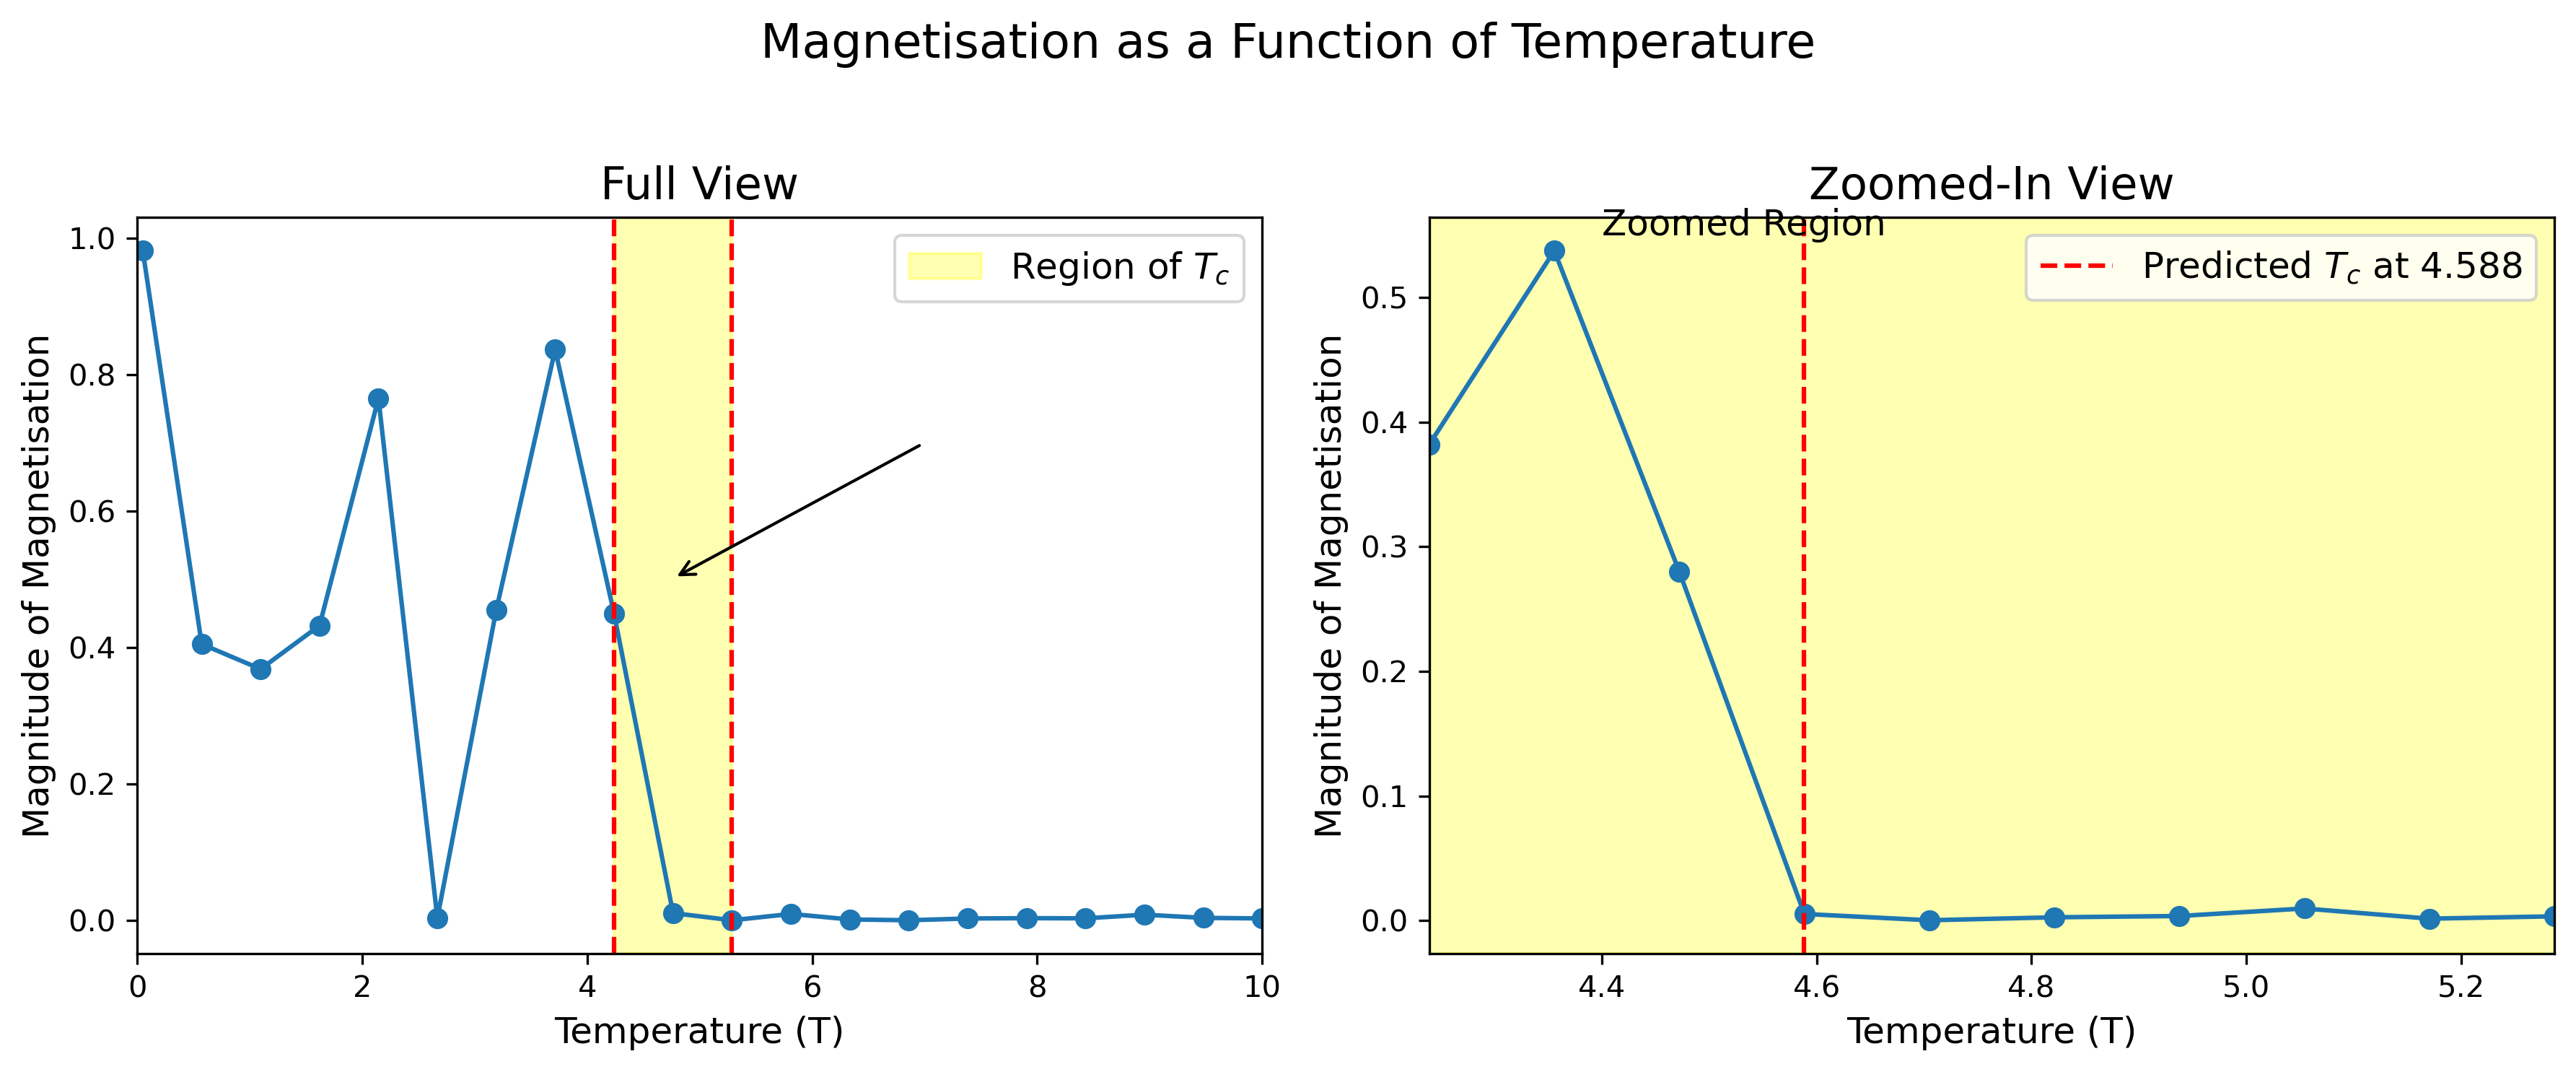

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# First plot (full view)
axs[0].plot(temperatures, magnetizations, '-o')
axs[0].axvline(x=4.239, color='r', linestyle='--')
axs[0].axvline(x=5.287, color='r', linestyle='--')
axs[0].axvspan(4.239, 5.287, color='yellow', alpha=0.3, label='Region of $T_c$')
axs[0].set_xlabel("Temperature (T)", fontsize=12)
axs[0].set_ylabel("Magnitude of Magnetisation", fontsize=12)
axs[0].set_xlim(0, 10)
axs[0].legend(fontsize="large")
axs[0].set_title("Full View", fontsize=15)

# Second plot (zoomed-in view)
axs[1].plot(temperatures2, magnetizations2, '-o')
axs[1].axvline(x=4.588, color='r', linestyle='--', label="Predicted $T_c$ at 4.588")
axs[1].axvspan(4.239, 5.287, color='yellow', alpha=0.3)
axs[1].set_xlabel("Temperature (T)", fontsize=12)
axs[1].set_ylabel("Magnitude of Magnetisation", fontsize=12)
axs[1].set_xlim(4.239, 5.287)
axs[1].legend(fontsize="large")
axs[1].set_title("Zoomed-In View", fontsize=15)

# Add a single, centralized title
fig.suptitle("Magnetisation as a Function of Temperature", fontsize=16)

# Add an annotation with an arrow to indicate zoom
axs[0].annotate(
    "",  # Empty text
    xy=(4.75, 0.5),  # Target point in the first plot
    xytext=(7, 0.7),  # Starting point of the arrow
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=12,
)
axs[1].text(4.4, 0.55, "Zoomed Region", fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [20]:
# Simulate for different temperatures
temperatures = np.linspace(4.239, 5.287, 10)
magnetizations = []

L = 64
steps = 1024

for T in temperatures:
    # Initialize the lattice
    print(T)
    lattice = initialise_lattice(L) 
    
    # Run the simulation
    for step in range(steps):
        monte_carlo_step(lattice, T, L, J, k_B)
    
    # After thermalization, calculate the average magnetization
    mag = np.abs(calc_mag(lattice)) / (L * L * L)  # Normalize by number of spins
    magnetizations.append(mag)



4.239
4.355444444444444
4.471888888888889
4.588333333333333
4.704777777777777
4.821222222222222
4.937666666666667
5.054111111111111
5.170555555555556
5.287


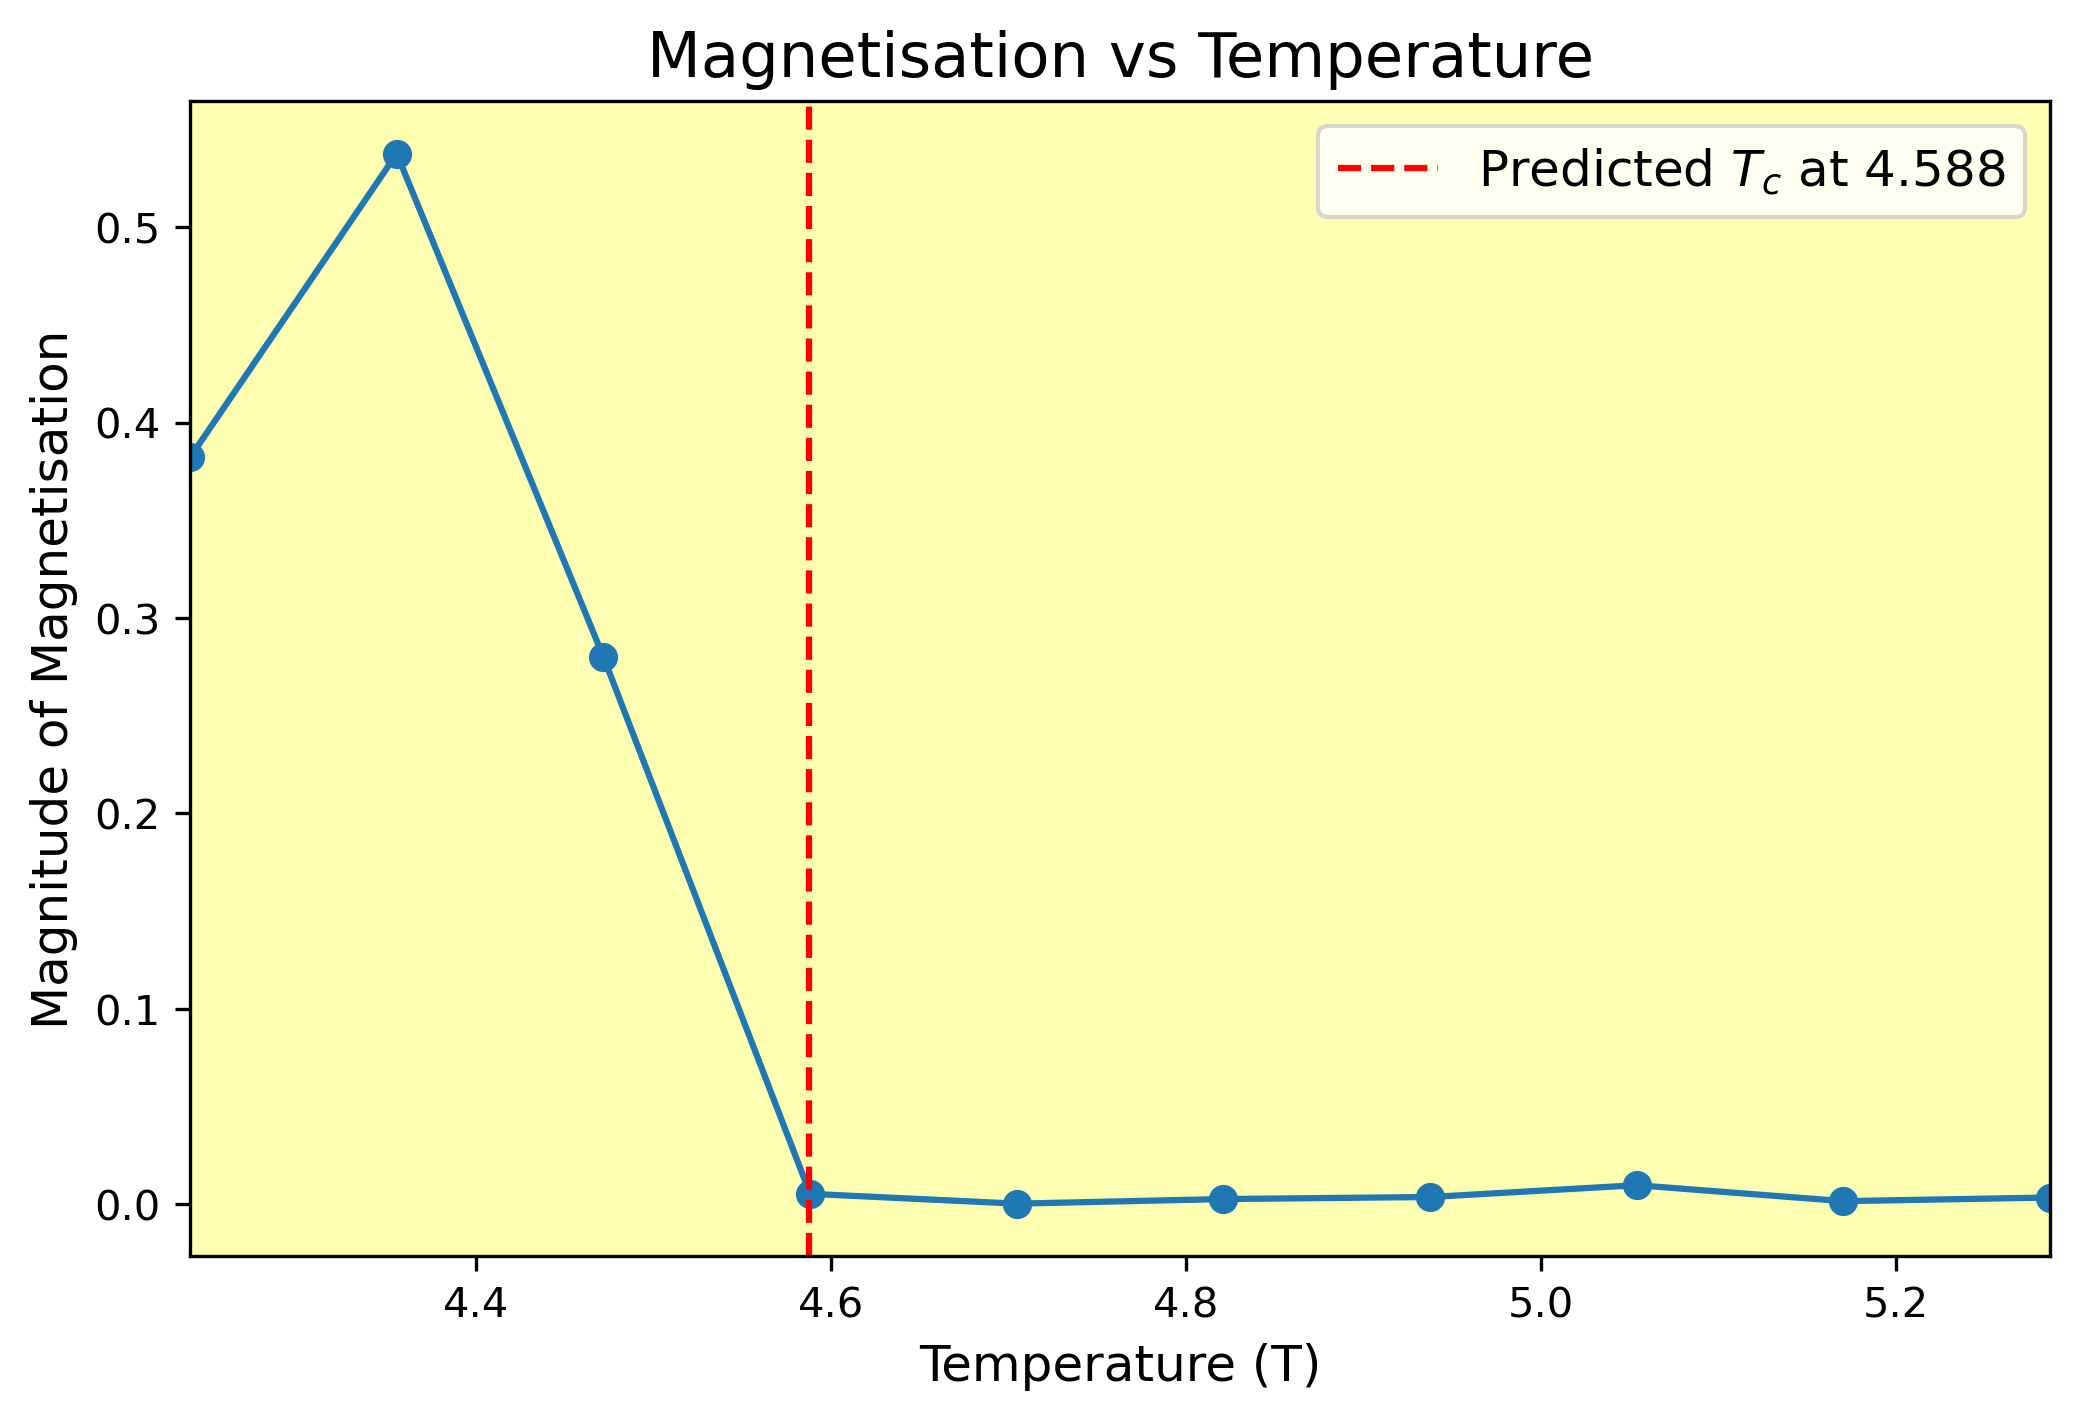

In [28]:
temperatures2 = np.linspace(4.239, 5.287, 10)

plt.figure(figsize=(8,5), dpi=300)
# increase dpi for better resolution

plt.plot(temperatures2, magnetizations2, '-o')
plt.axvline(x=4.588, color='r', linestyle='--', label = "Predicted $T_c$ at 4.588")
# plt.axvline(x=5.286, color='r', linestyle='--')
plt.axvspan(4.239, 5.287, color='yellow', alpha=0.3)
plt.xlabel("Temperature (T)", fontsize = 12)
plt.ylabel("Magnitude of Magnetisation", fontsize = 12)
plt.title("Magnetisation vs Temperature", fontsize = 15)
plt.xlim(4.239,5.287)
plt.legend(fontsize = "large")
plt.ion()
plt.show()

KeyboardInterrupt: 

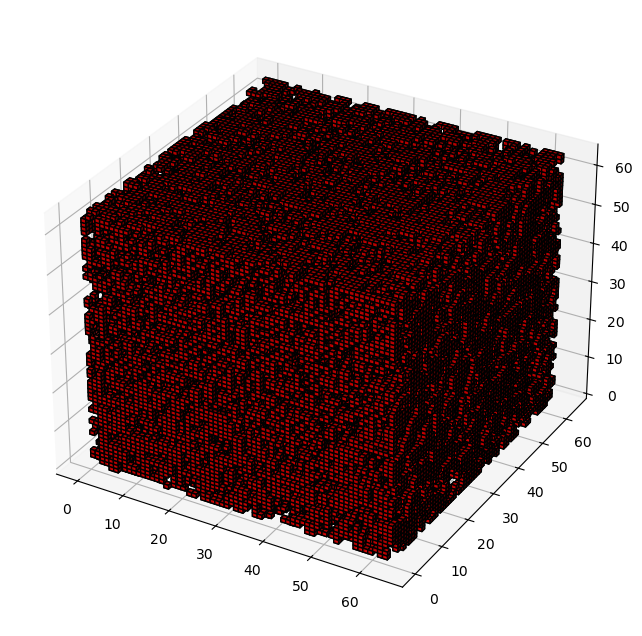

In [95]:
# Function to visualize a slice of the lattice in 2D (since 3D is hard to visualize directly)
def plot_lattice_slice(lattice, slice_index, title):
    plt.imshow(lattice[slice_index], cmap='gray', interpolation='none', vmin=-1, vmax=1)  # Show a 2D slice
    plt.title(title)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

# Function to plot the 3D lattice as voxels
def plot_3d_voxels(lattice):
    L = lattice.shape[0]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D grid of colors based on the spins (+1 = red, -1 = blue)
    colors = np.empty(lattice.shape, dtype=object)
    colors[lattice == 1] = 'red'
    colors[lattice == -1] = 'blue'

    # Create a voxel plot with color mapping
    ax.voxels(lattice == 1, facecolors=colors, edgecolor='k', alpha = 0.8)

    # Set labels
    # ax.set_xlabel('X axis')
    # ax.set_ylabel('Y axis')
    # ax.set_zlabel('Z axis')
    ax.set_title('3D Lattice Plot')

    plt.show()

# Example: Plot the final state of the lattice in 3D voxels
plot_3d_voxels(lattice_histories[-1])